# 🔧 System Diagnostic - Run This First!

Before training, we need to verify that the GPU is properly accessible. This cell will check:
1. Slurm job allocation
2. GPU hardware detection
3. CUDA environment variables
4. PyTorch CUDA compatibility
5. Common issues and solutions

**Run the diagnostic cell below FIRST before proceeding with training!**

In [1]:
#!/usr/bin/env python3
"""
Comprehensive GPU Diagnostic for HPC Cluster
This cell diagnoses why PyTorch might show "device: cpu" even on GPU nodes
"""

import subprocess
import sys
import os

print("="*80)
print(" 🔍 COMPREHENSIVE GPU DIAGNOSTIC FOR HPC CLUSTER")
print("="*80)
print()

# ============================================================================
# 1. SLURM JOB INFORMATION
# ============================================================================
print("1️⃣  SLURM JOB ALLOCATION")
print("-" * 80)

slurm_vars = {
    'SLURM_JOB_ID': 'Job ID',
    'SLURM_JOB_NODELIST': 'Assigned Node(s)',
    'SLURM_NODEID': 'Node ID',
    'SLURM_GPUS': 'Total GPUs Allocated',
    'SLURM_GPUS_ON_NODE': 'GPUs on This Node',
    'SLURM_JOB_GPUS': 'GPU IDs Allocated',
    'SLURM_CPUS_ON_NODE': 'CPUs on Node',
    'SLURM_MEM_PER_NODE': 'Memory per Node',
}

slurm_allocated = False
for var, desc in slurm_vars.items():
    value = os.environ.get(var, 'NOT SET')
    print(f"  {desc:25s}: {value}")
    if var in ['SLURM_GPUS', 'SLURM_GPUS_ON_NODE', 'SLURM_JOB_GPUS']:
        if value != 'NOT SET' and value != '0' and value != '':
            slurm_allocated = True

print()
if slurm_allocated:
    print("  ✅ Slurm has allocated GPU(s) to this job")
else:
    print("  ⚠️  WARNING: No GPU allocation detected by Slurm!")
    print("     This job may not have requested GPU resources.")
    print()

# ============================================================================
# 2. CUDA ENVIRONMENT VARIABLES
# ============================================================================
print()
print("2️⃣  CUDA ENVIRONMENT VARIABLES")
print("-" * 80)

cuda_vars = {
    'CUDA_VISIBLE_DEVICES': 'Which GPUs are visible to CUDA',
    'CUDA_HOME': 'CUDA installation directory',
    'CUDA_PATH': 'CUDA path',
    'CUDA_ROOT': 'CUDA root directory',
    'LD_LIBRARY_PATH': 'Library path (includes CUDA libs)',
}

cuda_env_ok = False
for var, desc in cuda_vars.items():
    value = os.environ.get(var, 'NOT SET')
    if var == 'LD_LIBRARY_PATH' and value != 'NOT SET':
        # Show only CUDA-related parts
        cuda_parts = [p for p in value.split(':') if 'cuda' in p.lower() or 'CUDA' in p]
        if cuda_parts:
            print(f"  {var:25s}: {cuda_parts[0]} (and {len(cuda_parts)-1} more)")
        else:
            print(f"  {var:25s}: (no CUDA paths found)")
    else:
        print(f"  {var:25s}: {value}")
    
    if var == 'CUDA_VISIBLE_DEVICES' and value != 'NOT SET':
        cuda_env_ok = True

print()
if cuda_env_ok:
    print("  ✅ CUDA_VISIBLE_DEVICES is set")
else:
    print("  ⚠️  WARNING: CUDA_VISIBLE_DEVICES not set!")
    print("     GPUs may not be visible to applications.")
    print()

# ============================================================================
# 3. GPU HARDWARE DETECTION (nvidia-smi)
# ============================================================================
print()
print("3️⃣  GPU HARDWARE DETECTION (nvidia-smi)")
print("-" * 80)

try:
    result = subprocess.run(
        ['nvidia-smi', '--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free',
         '--format=csv'],
        capture_output=True, text=True, timeout=5
    )
    
    if result.returncode == 0:
        print(result.stdout)
        print("  ✅ GPU hardware detected successfully")
        hardware_ok = True
    else:
        print(f"  ❌ nvidia-smi failed with error:\n{result.stderr}")
        hardware_ok = False
except FileNotFoundError:
    print("  ❌ nvidia-smi command not found!")
    print("     GPU drivers may not be installed.")
    hardware_ok = False
except Exception as e:
    print(f"  ❌ Error running nvidia-smi: {e}")
    hardware_ok = False

print()

# ============================================================================
# 4. CUDA TOOLKIT VERSION
# ============================================================================
print("4️⃣  CUDA TOOLKIT VERSION")
print("-" * 80)

try:
    result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, timeout=5)
    if result.returncode == 0:
        for line in result.stdout.split('\n'):
            if 'release' in line.lower():
                print(f"  System CUDA: {line.strip()}")
                # Extract version number
                import re
                match = re.search(r'release (\d+\.\d+)', line)
                if match:
                    cuda_version = match.group(1)
                    print(f"  CUDA Version: {cuda_version}")
    else:
        print("  ⚠️  nvcc not found (CUDA toolkit may not be in PATH)")
except Exception as e:
    print(f"  ⚠️  Could not determine CUDA version: {e}")

print()

# ============================================================================
# 5. PYTORCH CUDA DETECTION
# ============================================================================
print("5️⃣  PYTORCH CUDA DETECTION")
print("-" * 80)

try:
    import torch
    print(f"  PyTorch Version: {torch.__version__}")
    print(f"  PyTorch Built with CUDA: {torch.version.cuda}")
    print(f"  CUDA Available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"  CUDA Device Count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"    GPU {i}: {torch.cuda.get_device_name(i)}")
            props = torch.cuda.get_device_properties(i)
            print(f"      Total Memory: {props.total_memory / 1024**3:.2f} GB")
        print()
        print("  ✅ PyTorch can access GPU(s)!")
        pytorch_ok = True
    else:
        print()
        print("  ❌ PyTorch CANNOT access GPU!")
        pytorch_ok = False
        
        # Diagnose why
        print()
        print("  🔍 DIAGNOSIS:")
        
        # Check CUDA version mismatch
        if torch.version.cuda:
            pytorch_cuda = torch.version.cuda
            print(f"     - PyTorch was built for CUDA {pytorch_cuda}")
            
            # Try to get system CUDA version
            try:
                nvcc_result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, timeout=5)
                if nvcc_result.returncode == 0:
                    import re
                    match = re.search(r'release (\d+\.\d+)', nvcc_result.stdout)
                    if match:
                        system_cuda = match.group(1)
                        print(f"     - System has CUDA {system_cuda}")
                        
                        # Compare major versions
                        pytorch_major = pytorch_cuda.split('.')[0]
                        system_major = system_cuda.split('.')[0]
                        
                        if pytorch_major != system_major:
                            print()
                            print(f"     ⚠️  CUDA VERSION MISMATCH!")
                            print(f"         PyTorch needs CUDA {pytorch_major}.x")
                            print(f"         System has CUDA {system_major}.x")
                            print()
                            print(f"     💡 SOLUTION: Reinstall PyTorch with CUDA {system_major}.x support")
                            if system_major == '11':
                                print(f"         pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
                            elif system_major == '12':
                                print(f"         pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
            except:
                pass
        
        # Check if CUDA_VISIBLE_DEVICES is set
        if os.environ.get('CUDA_VISIBLE_DEVICES') == '':
            print("     - CUDA_VISIBLE_DEVICES is empty (no GPUs visible)")
        elif os.environ.get('CUDA_VISIBLE_DEVICES') is None:
            print("     - CUDA_VISIBLE_DEVICES is not set")
        
        # Check if Slurm allocated GPU
        if not slurm_allocated:
            print("     - Slurm did not allocate GPU to this job")
            print("       Did you request GPU with --gres=gpu:1?")

except ImportError:
    print("  ❌ PyTorch is not installed!")
    pytorch_ok = False

print()

# ============================================================================
# 6. SUMMARY & RECOMMENDATIONS
# ============================================================================
print("="*80)
print(" 📋 SUMMARY & RECOMMENDATIONS")
print("="*80)
print()

all_checks = {
    'Slurm GPU Allocation': slurm_allocated,
    'CUDA Environment': cuda_env_ok,
    'GPU Hardware (nvidia-smi)': hardware_ok,
    'PyTorch CUDA Access': pytorch_ok,
}

for check, status in all_checks.items():
    status_icon = "✅" if status else "❌"
    print(f"  {status_icon} {check}")

print()

if all(all_checks.values()):
    print("🎉 ALL CHECKS PASSED! GPU is ready for training.")
else:
    print("⚠️  ISSUES DETECTED. Review the diagnostic output above.")
    print()
    print("Common solutions:")
    print()
    print("1. If 'Slurm GPU Allocation' failed:")
    print("   - Make sure you started Jupyter with: bash slurm/start_jupyter.sh gpu7")
    print("   - Check job allocation: squeue -u $USER")
    print()
    print("2. If 'PyTorch CUDA Access' failed but hardware is OK:")
    print("   - Most likely CUDA version mismatch")
    print("   - Run the PyTorch reinstall cell below")
    print()
    print("3. If 'GPU Hardware' failed:")
    print("   - Job may be on a CPU-only node")
    print("   - Cancel and restart with: bash slurm/start_jupyter.sh gpu7")

print()
print("="*80)

 🔍 COMPREHENSIVE GPU DIAGNOSTIC FOR HPC CLUSTER

1️⃣  SLURM JOB ALLOCATION
--------------------------------------------------------------------------------
  Job ID                   : 3030862
  Assigned Node(s)         : gpu8
  Node ID                  : 0
  Total GPUs Allocated     : NOT SET
  GPUs on This Node        : 1
  GPU IDs Allocated        : 0
  CPUs on Node             : 2
  Memory per Node          : 16384

  ✅ Slurm has allocated GPU(s) to this job

2️⃣  CUDA ENVIRONMENT VARIABLES
--------------------------------------------------------------------------------
  CUDA_VISIBLE_DEVICES     : 0
  CUDA_HOME                : /prefix/software/CUDA/11.8.0
  CUDA_PATH                : /prefix/software/CUDA/11.8.0
  CUDA_ROOT                : /prefix/software/CUDA/11.8.0
  LD_LIBRARY_PATH          : /prefix/software/CUDA/11.8.0/nvvm/lib64 (and 2 more)

  ✅ CUDA_VISIBLE_DEVICES is set

3️⃣  GPU HARDWARE DETECTION (nvidia-smi)
---------------------------------------------------------

# Train Conditional UNet2D on Flickr8k with Text Captions + VAE

This notebook trains a **text-conditional** diffusion model on Flickr8k using:
- **Pretrained VAE** (AutoencoderKL from Stable Diffusion) to encode images to latents
- **Pretrained CLIP** text encoder for text embeddings
- **UNet2DConditionModel** (with cross-attention for text conditioning)
- **DDPM scheduler** for training and inference

## Key Design Choices
- Flickr8k images resized to 256x256
- Images normalized to [-1,1] for VAE compatibility
- VAE encodes to 32x32x4 latents
- CLIP encodes text captions to 77x768 embeddings
- Only the UNet is trained; VAE and CLIP are frozen
- **Text-conditional generation** - generate images from text prompts

## Memory Optimizations for GPU
- **Batch size**: 16 (adjustable based on GPU memory)
- **Image size**: 256x256
- **Mixed precision**: Enabled (FP16)
- **Cache clearing**: Periodic GPU cache clearing to prevent fragmentation
- **DataLoader**: num_workers=2, pin_memory=True for efficiency


# 🎨 Flickr8k Text-to-Image Conditional Diffusion Training

## About Flickr8k Dataset

1. **Dataset**: Flickr8k - 8,000 images from Flickr
2. **Captions**: 5 human-written captions per image (40,000 total captions)
3. **Content**: Diverse everyday scenes with people, animals, objects, and activities
4. **Image Complexity**: Natural photographs with varied subjects and backgrounds
5. **Text Descriptions**: Detailed natural language descriptions of image content
6. **Download**: Automatically loaded via HuggingFace datasets

## Quick Start

1. Run the diagnostic cell to verify GPU access
2. Configure training parameters (adjust batch size for your GPU)
3. Start training - checkpoints and sample images saved every 500 steps
4. Monitor progress through text-to-image samples
5. Generate images from custom text prompts!


## 1. Imports and Setup

## Memory Usage Tips

If you still encounter OOM errors, try these additional optimizations:

1. **Further reduce batch size**: Change `batch_size` to 8 or even 4
2. **Reduce image size**: Change `image_size` to 64 (will train faster but lower quality)
3. **Enable gradient checkpointing** (uncomment in UNet creation if available)
4. **Close other applications** that might be using GPU memory
5. **Restart the kernel** to clear any lingering memory allocations

Current settings should work on most 8GB GPUs with CUDA.

In [2]:
from __future__ import annotations

import os
import math
from dataclasses import dataclass
from typing import List, Optional

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffusers import DDPMScheduler
from diffusers.models import AutoencoderKL
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel

from transformers import CLIPTextModel, CLIPTokenizer

/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## IMPORTANT: CUDA Setup Check

If you see "Device: cpu" in the output above, it means PyTorch cannot access the GPU. This is usually because:

1. **CUDA version mismatch**: Your PyTorch is built for CUDA 12.x but the cluster has CUDA 11.x
2. **PyTorch not installed with CUDA support**

Run the diagnostic cell below to check and fix this issue.

In [3]:
# GPU Diagnostic and Fix
import subprocess
import sys

print("="*70)
print("GPU DIAGNOSTIC CHECK")
print("="*70)

# Check PyTorch version and CUDA support
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"CUDA version (PyTorch): {torch.version.cuda}")
        print(f"GPU device: {torch.cuda.get_device_name(0)}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print("\n✅ GPU is working correctly!")
    else:
        print("\n⚠️  PyTorch cannot access GPU!")
        
        # Check if nvidia-smi works
        try:
            result = subprocess.run(['nvidia-smi', '--query-gpu=name,driver_version,memory.total', 
                                   '--format=csv,noheader'], 
                                  capture_output=True, text=True, timeout=5)
            if result.returncode == 0:
                print(f"\nGPU hardware detected:")
                print(f"  {result.stdout.strip()}")
                
                # Check CUDA version on system
                cuda_result = subprocess.run(['nvcc', '--version'], 
                                           capture_output=True, text=True, timeout=5)
                if cuda_result.returncode == 0:
                    print(f"\nSystem CUDA:")
                    for line in cuda_result.stdout.split('\n'):
                        if 'release' in line.lower():
                            print(f"  {line.strip()}")
                
                print("\n" + "="*70)
                print("SOLUTION: Reinstall PyTorch with correct CUDA version")
                print("="*70)
                print("\nYour PyTorch was built for a different CUDA version than")
                print("what's available on this system.")
                print("\nTo fix this, run the following command:")
                print("\n  pip uninstall torch torchvision torchaudio -y")
                print("  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
                print("\nThis will install PyTorch with CUDA 11.8 support (matching your system).")
                print("\nWould you like to automatically fix this? (This will take a few minutes)")
                print("If yes, run the cell below.")
            else:
                print("\n❌ GPU hardware not detected by nvidia-smi")
                print("This job might not have GPU allocated!")
        except Exception as e:
            print(f"\nError checking GPU: {e}")
            
except ImportError:
    print("❌ PyTorch is not installed!")

print("="*70)

GPU DIAGNOSTIC CHECK
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version (PyTorch): 11.8
GPU device: NVIDIA A100 80GB PCIe
Number of GPUs: 1

✅ GPU is working correctly!


In [4]:
# AUTO-FIX: Reinstall PyTorch with correct CUDA version
# WARNING: This will uninstall and reinstall PyTorch (takes 3-5 minutes)
# Only run this cell if the diagnostic above showed CUDA is not available

# import subprocess
# import sys

# print("Uninstalling current PyTorch...")
# subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", 
#                       "torch", "torchvision", "torchaudio"])

# print("\nInstalling PyTorch with CUDA 11.8 support...")
# subprocess.check_call([sys.executable, "-m", "pip", "install", 
#                       "torch", "torchvision", "torchaudio",
#                       "--index-url", "https://download.pytorch.org/whl/cu118"])

# print("\nVerifying installation...")
# import torch
# print(f"PyTorch version: {torch.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")
# if torch.cuda.is_available():
#     print(f"CUDA version: {torch.version.cuda}")
#     print(f"GPU: {torch.cuda.get_device_name(0)}")
#     print("\n✅ GPU is now working!")
# else:
#     print("\n⚠️  Still having issues. Please check Slurm job GPU allocation.")

# print("\n⚠️  IMPORTANT: Restart the kernel after installing PyTorch!")
# print("   Go to: Kernel -> Restart Kernel")

## 2. Helper Functions

In [5]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def build_transforms(image_size: int = 256) -> transforms.Compose:
    """Transform Flickr8k images: resize to square, normalize to [-1,1] for VAE."""
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )


def seed_everything(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def encode_text(text: str, tokenizer, text_encoder, device):
    """Encode text prompt into embeddings using CLIP."""
    text_inputs = tokenizer(
        text,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids.to(device)
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input_ids)[0]
    
    return text_embeddings


## 3. Configuration

In [6]:
@dataclass
class TrainConfig:
    dataset_root: str
    output_dir: str = "./outputs/train12_flickr8k_text2img"
    batch_size: int = 16
    num_epochs: int = 5000
    lr: float = 1e-4
    num_train_timesteps: int = 1000
    image_size: int = 256
    seed: int = 42
    mixed_precision: bool = True
    checkpoint_interval: int = 500  # Save checkpoint every N steps
    # UNet size for Flickr8k (text-conditional)
    unet_block_out_channels: tuple[int, ...] = (128, 256, 512, 512)
    layers_per_block: int = 2
    # Text conditioning
    classifier_free_guidance_prob: float = 0.1  # 10% unconditional training for CFG


# Configure training parameters - OPTIMIZED FOR FLICKR8K TEXT-TO-IMAGE
config = TrainConfig(
    dataset_root="../../datasets",
    output_dir="./outputs/train12_flickr8k_text2img",
    batch_size=16,  # Adjust based on GPU memory
    num_epochs=5000,  # Train for 5000 epochs
    lr=1e-4,
    image_size=256,  # Full resolution for high-quality images
    mixed_precision=True,  # Enable mixed precision to save memory
    checkpoint_interval=500,  # Save checkpoint every 500 steps
    classifier_free_guidance_prob=0.1,  # Enable classifier-free guidance
)

print(f"Device: {get_device()}")
print(f"Batch size: {config.batch_size}")
print(f"Epochs: {config.num_epochs}")
print(f"Learning rate: {config.lr}")
print(f"Image size: {config.image_size}")
print(f"Output directory: {config.output_dir}")
print(f"Mixed precision: {config.mixed_precision}")
print(f"Checkpoint interval: {config.checkpoint_interval} steps")
print(f"Classifier-free guidance: {config.classifier_free_guidance_prob * 100}% unconditional")
print(f"\nDataset: Flickr8k (Text-Conditional Image Generation)")
print(f"Total training steps: ~{8000 // config.batch_size * config.num_epochs:,} (approx)")


Device: cuda
Batch size: 16
Epochs: 5000
Learning rate: 0.0001
Image size: 256
Output directory: ./outputs/train12_flickr8k_text2img
Mixed precision: True
Checkpoint interval: 500 steps
Classifier-free guidance: 10.0% unconditional

Dataset: Flickr8k (Text-Conditional Image Generation)
Total training steps: ~2,500,000 (approx)


## 4. Load Models

In [7]:
def create_models(device: torch.device, config: TrainConfig):
    # Pretrained VAE and CLIP text encoder/tokenizer
    print("Loading pretrained VAE...")
    vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
    vae.requires_grad_(False)
    vae.eval()
    vae.to(device)

    print("Loading CLIP text encoder...")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder.requires_grad_(False)
    text_encoder.eval()
    text_encoder.to(device)

    print("Creating UNet2DConditionModel...")
    # Conditional UNet operating in latent space (4 channels)
    # Larger model for CIFAR10's more complex images
    unet = UNet2DConditionModel(
        sample_size=config.image_size // 8,  # 32 for 256x256
        in_channels=4,
        out_channels=4,
        layers_per_block=config.layers_per_block,
        block_out_channels=config.unet_block_out_channels,
        down_block_types=(
            "DownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "CrossAttnUpBlock2D",
            "CrossAttnUpBlock2D",
            "UpBlock2D",
        ),
        cross_attention_dim=512,  # CLIP ViT-B/32 hidden size
    ).to(device)

    num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f"UNet trainable parameters: {num_params:,}")

    return vae, tokenizer, text_encoder, unet


# Initialize models
device = get_device()
seed_everything(config.seed)
vae, tokenizer, text_encoder, unet = create_models(device, config)

Loading pretrained VAE...
Loading CLIP text encoder...
Creating UNet2DConditionModel...
UNet trainable parameters: 137,372,932


## 5. Prepare Dataset

In [8]:
def make_dataloader(config: TrainConfig) -> DataLoader:
    """Load Flickr8k dataset with captions using HuggingFace datasets with LOCAL DOWNLOAD."""
    import random
    
    # IMPORTANT: Set HuggingFace cache directory BEFORE importing datasets
    # Use /home/doshlom4/work for disk quota
    cache_dir = "/home/doshlom4/work/huggingface_cache"
    os.environ['HF_HOME'] = cache_dir
    os.environ['HF_DATASETS_CACHE'] = cache_dir
    os.environ['TRANSFORMERS_CACHE'] = cache_dir
    
    # Now import datasets after setting environment variables
    from datasets import load_dataset
    from torch.utils.data import Dataset
    
    print("Loading Flickr8k dataset with LOCAL DOWNLOAD...")
    print(f"📁 Cache directory: {cache_dir}")
    
    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)
    
    # Try multiple Flickr8k dataset sources with LOCAL DOWNLOAD
    dataset_candidates = [
        ("nlphuji/flickr30k", "test"),
        ("nlphuji/flickr30k", "train"),
    ]
    
    ds = None
    for dataset_name, split_name in dataset_candidates:
        try:
            print(f"Trying to load: {dataset_name} (split={split_name})...")
            print(f"This will download the dataset to {cache_dir}")
            
            # Use streaming=False to download locally
            ds = load_dataset(
                dataset_name, 
                split=split_name, 
                cache_dir=cache_dir,
                streaming=False  # Download dataset locally
            )
            
            print(f"✅ Successfully loaded {dataset_name} locally")
            print(f"✅ Dataset has {len(ds)} examples")
            break
        except Exception as e:
            print(f"⚠️  Failed to load {dataset_name}: {e}")
            continue
    
    if ds is None:
        raise RuntimeError(
            "Could not load any Flickr dataset. Please check your internet connection and disk space."
        )
    
    tfms = build_transforms(config.image_size)
    
    # Dataset wrapper for Flickr8k with text captions
    class Flickr8kTextImageDataset(Dataset):
        def __init__(self, hf_dataset, transform, cfg_prob=0.1):
            """
            Args:
                hf_dataset: HuggingFace dataset (downloaded locally)
                transform: Image transformations
                cfg_prob: Probability of dropping text for classifier-free guidance
            """
            self.dataset = hf_dataset
            self.transform = transform
            self.cfg_prob = cfg_prob
            
        def __len__(self):
            return len(self.dataset)
            
        def __getitem__(self, idx):
            max_retries = 5
            for retry in range(max_retries):
                try:
                    example = self.dataset[idx % len(self.dataset)]
                    
                    # Get image - handle different field names
                    image = example.get('image', None) or example.get('img', None) or example.get('jpg', None)
                    if image is None:
                        idx = (idx + 1) % len(self.dataset)
                        continue
                        
                    if image.mode != 'RGB':
                        image = image.convert('RGB')
                    image = self.transform(image)
                    
                    # Get caption - handle different dataset formats
                    caption = ""
                    
                    # Try different caption field names
                    if 'caption' in example:
                        captions = example['caption']
                        if isinstance(captions, list) and len(captions) > 0:
                            caption = random.choice(captions)
                        elif isinstance(captions, str):
                            caption = captions
                    elif 'captions' in example:
                        captions = example['captions']
                        if isinstance(captions, list) and len(captions) > 0:
                            caption = random.choice(captions)
                        elif isinstance(captions, str):
                            caption = captions
                    elif 'sentences' in example:
                        sentences = example['sentences']
                        if isinstance(sentences, list) and len(sentences) > 0:
                            sent = random.choice(sentences)
                            if isinstance(sent, dict):
                                caption = sent.get('raw', '') or sent.get('text', '')
                            else:
                                caption = str(sent)
                    elif 'text' in example:
                        caption = example['text']
                    
                    # Fallback: use any string field
                    if not caption:
                        for key, value in example.items():
                            if isinstance(value, str) and len(value) > 10:
                                caption = value
                                break
                    
                    # For classifier-free guidance: randomly drop text
                    if random.random() < self.cfg_prob:
                        caption = ""
                    
                    return {'image': image, 'caption': caption}
                    
                except Exception as e:
                    print(f"Error loading example {idx}: {e}, retrying...")
                    idx = (idx + 1) % len(self.dataset)
                    if retry == max_retries - 1:
                        raise
    
    dataset = Flickr8kTextImageDataset(ds, tfms, config.classifier_free_guidance_prob)
    
    print(f"Dataset size: {len(dataset)}")
    
    # Use multiple workers for faster data loading
    return DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True,  # Drop incomplete batches
    )


# Create dataloader
print("="*80)
dataloader = make_dataloader(config)
print("="*80)
print("✅ Dataset loaded successfully")
print(f"Dataset size: {len(dataloader.dataset)}")
print(f"Batch size: {config.batch_size}")
print(f"Number of batches: {len(dataloader)}")


Loading Flickr8k dataset with LOCAL DOWNLOAD...
📁 Cache directory: /home/doshlom4/work/huggingface_cache
Trying to load: nlphuji/flickr30k (split=test)...
This will download the dataset to /home/doshlom4/work/huggingface_cache
✅ Successfully loaded nlphuji/flickr30k locally
✅ Dataset has 31014 examples
Dataset size: 31014
✅ Dataset loaded successfully
Dataset size: 31014
Batch size: 16
Number of batches: 1938


## 6. Visualize Sample Data

Loading sample batch...
Batch shape: torch.Size([16, 3, 256, 256])

Sample captions:
  1. Two people in a busy Chinese street area handling food.
  2. A man shuffling cards over a black counter with keys and some poker chips on it.
  3. Several people watch a presentation on stage with varying degrees of interest.
  4. A cowboy waves a lasso in the air at a horse show.


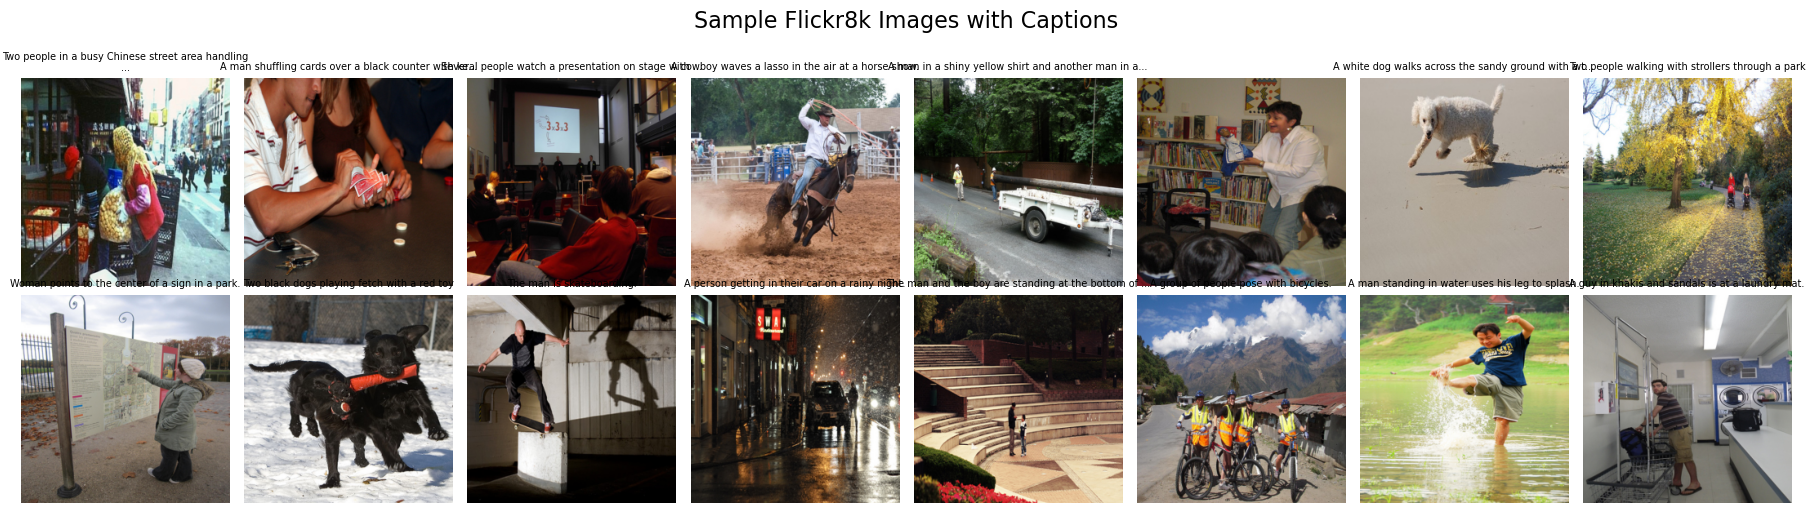

In [9]:
# Visualize a batch with captions
print("Loading sample batch...")
sample_batch = next(iter(dataloader))
sample_images = sample_batch['image']
sample_captions = sample_batch['caption']

print(f"Batch shape: {sample_images.shape}")
print(f"\nSample captions:")
for i, caption in enumerate(sample_captions[:4]):
    print(f"  {i+1}. {caption}")

fig, axes = plt.subplots(2, 8, figsize=(18, 5))
for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        img = sample_images[i].permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
        ax.imshow(img)
        ax.axis('off')
        # Add caption as title (truncated)
        if i < len(sample_captions):
            caption = sample_captions[i][:50] + "..." if len(sample_captions[i]) > 50 else sample_captions[i]
            ax.set_title(caption, fontsize=7, wrap=True)
            
plt.suptitle("Sample Flickr8k Images with Captions", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

del sample_batch, sample_images, sample_captions
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


## 8. Training Loop

## 7. Checkpoint Management Functions

In [10]:
def find_latest_checkpoint(output_dir: str):
    """Find the latest checkpoint in the output directory."""
    if not os.path.exists(output_dir):
        return None
    
    # Look for checkpoint files
    checkpoint_files = []
    for filename in os.listdir(output_dir):
        if filename.endswith('.pt') and (filename.startswith('unet_step_') or filename.startswith('unet_epoch_')):
            filepath = os.path.join(output_dir, filename)
            checkpoint_files.append(filepath)
    
    if not checkpoint_files:
        return None
    
    # Get the most recently modified checkpoint
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    return latest_checkpoint


def load_checkpoint(checkpoint_path: str, unet, optimizer=None):
    """Load checkpoint and return metadata."""
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict):
        if 'unet' in checkpoint:
            unet.load_state_dict(checkpoint['unet'])
        else:
            unet.load_state_dict(checkpoint)
        
        # Load optimizer state if available
        if optimizer is not None and 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        
        # Extract metadata
        metadata = {
            'global_step': checkpoint.get('global_step', checkpoint.get('step', 0)),
            'epoch': checkpoint.get('epoch', 0),
            'batch_losses': checkpoint.get('batch_losses', []),
            'epoch_losses': checkpoint.get('epoch_losses', []),
        }
    else:
        unet.load_state_dict(checkpoint)
        metadata = {'global_step': 0, 'epoch': 0, 'batch_losses': [], 'epoch_losses': []}
    
    print(f"Resumed from step {metadata['global_step']}, epoch {metadata['epoch']}")
    return metadata


def save_checkpoint(path: str, unet, optimizer, global_step: int, epoch: int, 
                   batch_losses: List[float], epoch_losses: List[float]):
    """Save checkpoint with complete metadata."""
    checkpoint = {
        'unet': unet.state_dict(),
        'optimizer': optimizer.state_dict(),
        'global_step': global_step,
        'epoch': epoch,
        'batch_losses': batch_losses,
        'epoch_losses': epoch_losses,
    }
    torch.save(checkpoint, path)


# Check for existing checkpoints
latest_checkpoint = find_latest_checkpoint(config.output_dir)
if latest_checkpoint:
    print(f"Found existing checkpoint: {latest_checkpoint}")
    print("Training will resume from this checkpoint.")
else:
    print("No existing checkpoints found. Starting training from scratch.")

Found existing checkpoint: ./outputs/train12_flickr8k_text2img/unet_step_47000.pt
Training will resume from this checkpoint.


### Checkpoint System Features

The checkpoint system provides:

1. **Automatic Resume**: Detects and loads the latest checkpoint automatically
2. **Complete Metadata**: Each checkpoint stores:
   - UNet model weights
   - Optimizer state (for proper resume)
   - Global step count
   - Current epoch number
   - Complete batch loss history
   - Complete epoch loss history
3. **Training Plots**: Loss plots saved with every checkpoint
4. **Sample Images**: Generated samples (all 10 CIFAR10 classes) saved at each checkpoint to visualize training progress
5. **Multiple Checkpoint Types**:
   - Step checkpoints: `unet_step_2000.pt` (every 2000 steps)
   - Epoch checkpoints: `unet_epoch_1.pt` (after each epoch)
   - Final checkpoint: `unet_final.pt` (at completion)
   - Sample images: `samples_step_2000.png`, `samples_epoch_1.png`, `samples_final.png`

If training is interrupted, simply re-run the training cell and it will automatically resume from the latest checkpoint!

In [11]:
def generate_checkpoint_samples(
    unet, vae, text_encoder, tokenizer, device, config, 
    save_path: str, global_step: int, num_samples: int = 16, num_inference_steps: int = 50
):
    """Generate sample images from text prompts during training checkpoints."""
    print(f"\nGenerating {num_samples} text-to-image samples at step {global_step}...")
    
    # Predefined interesting prompts for visualization
    prompts = [
        "A dog running on the beach",
        "A child playing with a ball",
        "A person riding a bike",
        "A cat sitting on a chair",
        "People walking in a park",
        "A bird in a tree",
        "A man with a hat",
        "A woman smiling",
        "Children playing outside",
        "A dog jumping in the air",
        "A person holding an umbrella",
        "A group of people standing",
        "A child with a toy",
        "A dog with a stick",
        "A person near water",
        "Two people talking",
    ]
    
    # Create scheduler for sampling
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)
    
    # Set models to eval mode
    unet.eval()
    
    fig, axes = plt.subplots(2, 8, figsize=(20, 6))
    
    with torch.no_grad():
        for i, ax in enumerate(axes.flat):
            if i >= num_samples:
                ax.axis('off')
                continue
            
            # Get prompt and encode
            prompt = prompts[i % len(prompts)]
            text_embeddings = encode_text(prompt, tokenizer, text_encoder, device)
            
            # Set seed for reproducibility
            torch.manual_seed(42 + i)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(42 + i)
            
            # Init random latents
            latents = torch.randn((1, 4, config.image_size // 8, config.image_size // 8), device=device)
            
            # Denoising loop with text conditioning
            for t in scheduler.timesteps:
                latent_model_input = scheduler.scale_model_input(latents, t)
                
                # Predict noise with text conditioning
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
                
                # Step
                latents = scheduler.step(noise_pred, t, latents).prev_sample
            
            # Decode latents to image
            latents = latents / 0.18215
            image = vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.detach().cpu()
            
            # Display image with prompt as title
            img = image[0].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(prompt[:40], fontsize=7)
    
    plt.suptitle(f"Text-to-Image Samples at Step {global_step}", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Sample images saved: {save_path}")
    
    # Set UNet back to train mode
    unet.train()


In [12]:
def train(config: TrainConfig, vae, tokenizer, text_encoder, unet, dataloader, device, resume_from_checkpoint: str = None):
    os.makedirs(config.output_dir, exist_ok=True)

    # Noise scheduler for training
    noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps, beta_schedule="squaredcos_cap_v2")

    optimizer = torch.optim.AdamW(unet.parameters(), lr=config.lr)
    scaler = torch.amp.GradScaler('cuda', enabled=config.mixed_precision and device.type == "cuda")

    # Loss tracking and training state
    batch_losses = []
    epoch_losses = []
    global_step = 0
    start_epoch = 0
    
    # Resume from checkpoint if available
    if resume_from_checkpoint:
        metadata = load_checkpoint(resume_from_checkpoint, unet, optimizer)
        global_step = metadata['global_step']
        start_epoch = metadata['epoch']
        batch_losses = metadata['batch_losses']
        epoch_losses = metadata['epoch_losses']
        print(f"Resuming training from step {global_step}, epoch {start_epoch}")

    unet.train()
    
    for epoch in range(start_epoch, config.num_epochs):
        epoch_loss_sum = 0.0
        epoch_batch_count = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config.num_epochs}")
        
        for batch_idx, batch in enumerate(pbar):
            # Get images and captions from batch
            images = batch['image'].to(device, non_blocking=True)
            captions = batch['caption']

            with torch.no_grad():
                # Encode images to latents using frozen VAE
                latents = vae.encode(images).latent_dist.sample() * 0.18215
                
                # Encode text prompts using frozen CLIP
                text_embeddings = []
                for caption in captions:
                    emb = encode_text(caption, tokenizer, text_encoder, device)
                    text_embeddings.append(emb)
                text_embeddings = torch.cat(text_embeddings, dim=0)

            # Sample noise and timestep; add noise
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Predict noise with text conditioning
            with torch.autocast(
                device_type=device.type,
                dtype=torch.float16 if (config.mixed_precision and device.type == "cuda") else torch.float32,
                enabled=config.mixed_precision
            ):
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample
                loss = nn.functional.mse_loss(noise_pred, noise)

            optimizer.zero_grad(set_to_none=True)
            if scaler.is_enabled():
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            # Record loss
            loss_value = loss.item()
            batch_losses.append(loss_value)
            epoch_loss_sum += loss_value
            epoch_batch_count += 1

            global_step += 1
            pbar.set_postfix({"loss": f"{loss_value:.4f}", "step": global_step})

            # Clear cache every 50 batches to prevent fragmentation
            if batch_idx % 50 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Save periodic checkpoints
            if global_step % config.checkpoint_interval == 0:
                ckpt_path = os.path.join(config.output_dir, f"unet_step_{global_step}.pt")
                save_checkpoint(ckpt_path, unet, optimizer, global_step, epoch, batch_losses, epoch_losses)
                print(f"\nCheckpoint saved: {ckpt_path}")
                
                # Save training plots with the checkpoint
                plot_path = os.path.join(config.output_dir, f"training_loss_step_{global_step}.png")
                save_loss_plot(batch_losses, epoch_losses, plot_path)
                print(f"Training plot saved: {plot_path}")
                
                # Generate and save sample images
                samples_path = os.path.join(config.output_dir, f"samples_step_{global_step}.png")
                generate_checkpoint_samples(
                    unet, vae, text_encoder, tokenizer, device, config,
                    save_path=samples_path, global_step=global_step
                )
                
                # Clear cache after sampling
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        # Record epoch average loss
        avg_epoch_loss = epoch_loss_sum / epoch_batch_count if epoch_batch_count > 0 else 0.0
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{config.num_epochs} - Average Loss: {avg_epoch_loss:.4f}")

        # Save per-epoch checkpoint
        ckpt_path = os.path.join(config.output_dir, f"unet_epoch_{epoch+1}.pt")
        save_checkpoint(ckpt_path, unet, optimizer, global_step, epoch + 1, batch_losses, epoch_losses)
        
        # Save training plots with epoch checkpoint
        plot_path = os.path.join(config.output_dir, f"training_loss_epoch_{epoch+1}.png")
        save_loss_plot(batch_losses, epoch_losses, plot_path)
        print(f"Training plot saved: {plot_path}")
        
        # Generate and save sample images at end of epoch
        samples_path = os.path.join(config.output_dir, f"samples_epoch_{epoch+1}.png")
        generate_checkpoint_samples(
            unet, vae, text_encoder, tokenizer, device, config,
            save_path=samples_path, global_step=global_step
        )
        
        # Clear cache after each epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save final
    final_path = os.path.join(config.output_dir, "unet_final.pt")
    save_checkpoint(final_path, unet, optimizer, global_step, config.num_epochs, batch_losses, epoch_losses)
    print(f"\nFinal model saved: {final_path}")
    
    # Save final training plots
    final_plot_path = os.path.join(config.output_dir, "training_loss_final.png")
    save_loss_plot(batch_losses, epoch_losses, final_plot_path)
    print(f"Final training plot saved: {final_plot_path}")
    
    # Generate final sample images
    final_samples_path = os.path.join(config.output_dir, "samples_final.png")
    generate_checkpoint_samples(
        unet, vae, text_encoder, tokenizer, device, config,
        save_path=final_samples_path, global_step=global_step
    )

    return batch_losses, epoch_losses


def save_loss_plot(batch_losses: List[float], epoch_losses: List[float], save_path: str):
    """Helper function to save loss plots without displaying them."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Per-batch loss
    if len(batch_losses) > 0:
        axes[0].plot(batch_losses, linewidth=0.8, alpha=0.7)
        axes[0].set_xlabel("Batch")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Training Loss per Batch")
        axes[0].grid(True, alpha=0.3)

    # Per-epoch loss
    if len(epoch_losses) > 0:
        axes[1].plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linewidth=2)
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Average Loss")
        axes[1].set_title("Training Loss per Epoch")
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close(fig)  # Close the figure to free memory


## 9. Run Training

## 8.5. Memory Optimization (Clear GPU Cache)

In [13]:
# Clear GPU cache before training to maximize available memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    # Set memory allocation configuration for better fragmentation handling
    import os
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Print current memory status
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU Memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    print("Memory cache cleared and optimized for training")

GPU Memory allocated: 1.07 GB
GPU Memory reserved: 1.09 GB
Memory cache cleared and optimized for training


In [ ]:
# Check for existing checkpoints and resume if available
latest_checkpoint = find_latest_checkpoint(config.output_dir)

# Train the model (will resume from checkpoint if found)
batch_losses, epoch_losses = train(
    config, vae, tokenizer, text_encoder, unet, dataloader, device, 
    resume_from_checkpoint=latest_checkpoint
)

Loading checkpoint from: ./outputs/train12_flickr8k_text2img/unet_step_47000.pt
Resumed from step 47000, epoch 24
Resuming training from step 47000, epoch 24


Epoch 25/5000:  26%|██▌       | 499/1938 [02:25<06:52,  3.49it/s, loss=0.3430, step=47500]


Checkpoint saved: ./outputs/train12_flickr8k_text2img/unet_step_47500.pt
Training plot saved: ./outputs/train12_flickr8k_text2img/training_loss_step_47500.png

Generating 16 text-to-image samples at step 47500...


Epoch 25/5000:  26%|██▌       | 500/1938 [02:52<3:19:23,  8.32s/it, loss=0.3430, step=47500]

Sample images saved: ./outputs/train12_flickr8k_text2img/samples_step_47500.png


Epoch 25/5000:  52%|█████▏    | 999/1938 [05:16<04:30,  3.48it/s, loss=0.2970, step=48000]  


Checkpoint saved: ./outputs/train12_flickr8k_text2img/unet_step_48000.pt
Training plot saved: ./outputs/train12_flickr8k_text2img/training_loss_step_48000.png

Generating 16 text-to-image samples at step 48000...


Epoch 25/5000:  52%|█████▏    | 1000/1938 [05:42<2:08:42,  8.23s/it, loss=0.2970, step=48000]

Sample images saved: ./outputs/train12_flickr8k_text2img/samples_step_48000.png


Epoch 25/5000:  57%|█████▋    | 1109/1938 [06:14<03:57,  3.49it/s, loss=0.2589, step=48109]  

## 10. Visualize Training Loss

In [ ]:
def plot_losses(batch_losses: List[float], epoch_losses: List[float], output_dir: str = None):
    """Generate and save loss plots for per-batch and per-epoch losses."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Per-batch loss
    axes[0].plot(batch_losses, linewidth=0.8, alpha=0.7)
    axes[0].set_xlabel("Batch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Loss per Batch")
    axes[0].grid(True, alpha=0.3)

    # Per-epoch loss
    if len(epoch_losses) > 0:
        axes[1].plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linewidth=2)
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Average Loss")
        axes[1].set_title("Training Loss per Epoch")
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    
    if output_dir:
        loss_plot_path = os.path.join(output_dir, "training_loss.png")
        plt.savefig(loss_plot_path, dpi=150)
        print(f"Loss plots saved to {loss_plot_path}")
    
    plt.show()


# Plot the losses
plot_losses(batch_losses, epoch_losses, config.output_dir)

## 11. Sampling Function

In [ ]:
@torch.no_grad()
def sample(
    prompt: str,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    seed: Optional[int] = None,
):
    """Generate an image from a text prompt.
    
    Args:
        prompt: Text description of the image to generate
        num_inference_steps: Number of denoising steps
        guidance_scale: Classifier-free guidance scale (higher = more prompt adherence)
        seed: Random seed for reproducibility
    """
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Encode text prompt
    text_embeddings = encode_text(prompt, tokenizer, text_encoder, device)
    
    # For classifier-free guidance, also encode empty prompt
    if guidance_scale > 1.0:
        uncond_embeddings = encode_text("", tokenizer, text_encoder, device)
        # Concatenate for batch processing
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Init random latents in latent space
    latents = torch.randn((1, 4, config.image_size // 8, config.image_size // 8), device=device)

    unet.eval()
    for t in tqdm(scheduler.timesteps, desc=f"Generating '{prompt}'"):
        # Prepare latent input
        latent_model_input = latents
        if guidance_scale > 1.0:
            latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict noise with text conditioning
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform classifier-free guidance
        if guidance_scale > 1.0:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Step
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image
    latents = latents / 0.18215
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu()

    return image


## 12. Generate Samples

In [ ]:
# Generate images from various text prompts
test_prompts = [
    "A dog running on the beach",
    "A child playing with a ball",
    "A person riding a bike",
    "A cat sitting on a chair",
    "People walking in a park",
    "A bird in a tree",
    "A man with a hat",
    "A woman smiling",
    "Children playing outside",
    "A dog jumping in the air",
    "A person holding an umbrella",
    "A group of people standing",
    "A child with a toy",
    "A dog with a stick",
    "A person near water",
    "Two people talking",
]

num_inference_steps = 50
guidance_scale = 7.5

fig, axes = plt.subplots(4, 4, figsize=(18, 18))
for i, ax in enumerate(axes.flat):
    if i < len(test_prompts):
        prompt = test_prompts[i]
        print(f"Generating {i+1}/{len(test_prompts)}: '{prompt}'")
        generated_image = sample(
            prompt=prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            seed=42 + i,
        )
        
        # Display image
        img = generated_image[0].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(prompt, fontsize=9, wrap=True)
    else:
        ax.axis('off')

plt.suptitle("Text-to-Image Samples from Flickr8k Model", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, "text_to_image_samples.png"), dpi=150)
plt.show()


## 13. Test Different Guidance Scales

In [ ]:
# Test different guidance scales for a single prompt
test_prompt = "A happy dog playing with a ball in a park"
guidance_scales = [0, 3, 5, 7.5, 10, 15]

fig, axes = plt.subplots(1, len(guidance_scales), figsize=(20, 4))
for ax, gs in zip(axes, guidance_scales):
    print(f"Generating with guidance scale {gs}")
    generated_image = sample(
        prompt=test_prompt,
        guidance_scale=gs,
        num_inference_steps=50,
        seed=42,
    )
    
    img = generated_image[0].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Guidance Scale: {gs}")
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, "guidance_scale_comparison.png"), dpi=150)
plt.show()


## 14. Save Individual Sample

In [ ]:
# Generate and save a single high-quality sample from a custom prompt
from torchvision.utils import save_image

# CUSTOMIZE YOUR PROMPT HERE
custom_prompt = "A happy dog playing with a ball in a sunny park"

print(f"Generating image for prompt: '{custom_prompt}'")

generated_image = sample(
    prompt=custom_prompt,
    num_inference_steps=50,
    guidance_scale=7.5,
    seed=42,
)

# Save to file
output_path = os.path.join(config.output_dir, "custom_text_to_image.png")
save_image(generated_image, output_path)
print(f"Sample saved to: {output_path}")

# Display
plt.figure(figsize=(8, 8))
img = generated_image[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(f"Generated: '{custom_prompt}'", fontsize=12, wrap=True)
plt.axis('off')
plt.tight_layout()
plt.show()
